In [1]:
import warnings
import pandas as pd
from data_analysis.DataProcessor import DataProcessor

warnings.simplefilter(action='ignore', category=FutureWarning)

# read in combined stock data
preprocessor = DataProcessor()
# create df to current date
df = preprocessor.process_nrw_data("06_27")

# ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

File already exists: C:\Users\FelixNeubauer\UniRepos\webscraper\data_analysis\processed_nrw_data\06_27_nrw_stock_data.csv. Loading DataFrame from file.


In [2]:
# show columns
df.columns

Index(['id', 'timestamp', 'main_category', 'sub_category', 'product_name',
       'brand', 'price', 'store_skuId', 'store_storeId', 'store_storeName',
       'store_quantity', 'store_availabilityInfo', 'store_clickNcollect1h'],
      dtype='object')

In [3]:
# show all unique values and their count of sub_category, store_storeName and availabilityInfo
sub_category_counts = df['sub_category'].value_counts()
store_name_counts = df['store_storeName'].value_counts()
store_quantity_positive_count = (df['store_quantity'] > 0).sum()

store_quantity_zero_count = (df['store_quantity'] == 0).sum()
print("Unique values and counts for 'sub_category':")
print(sub_category_counts)
print("\nUnique values and counts for 'store_storeName':")
print(store_name_counts)
print("\nCount of entries with 'store_quantity' > 0:", store_quantity_positive_count)
print("Count of entries with 'store_quantity' = 0:", store_quantity_zero_count)

Unique values and counts for 'sub_category':
sub_category
fahrrader                       50643
schlafsacke-matratzen-betten    24586
fitnessgerate-fur-zuhause       23789
campingmobel                    23252
kochen-essen-trinken-camping    21186
zelte                           17192
Name: count, dtype: int64

Unique values and counts for 'store_storeName':
store_storeName
Dortmund-Kampstrasse     13929
Dortmund-Aplerbeck       13754
Herne                    13742
Wuppertal                13682
Köln-Quincy              13663
Essen                    13614
Düsseldorf               13498
Hagen                    13482
Köln Marsdorf            13478
Neuss                    13433
MÜNSTER                  12771
Hückelhoven              11602
Name: count, dtype: Int64

Count of entries with 'store_quantity' > 0: 78521
Count of entries with 'store_quantity' = 0: 82127


## Influence of Stock Outs

The goal of the analysis is to identify an influence of stock outs in neighboring stores on the demand of product variants. A product has an id and store_skuId (the skuId marks i.e. the size or color) - so just the combination makes the product unique (-> product variant). A product variant can be in several stores. So belonging to a store (store Id), just makes the product variant then unique per store. 

The "state" of the quantity of this product variant can change by time in each store (can be found out chronologically by the timestamp). 

A stock out event can be defined as the state of the quantity of a product variant in a store is 0, and was >0 in the measurement before. 

To measure an influence, it's important to only observe variants, which are sold in several stores. We set the minimum number of stores, a product variant has to be sold in, to 5. Further, we only consider product variants with at least 2 stock out events in the observation period across all stores.


In [4]:
# Group by id, store_skuId, and store_storeId to find the number of stores per product variant
product_store_counts = df.groupby(['id', 'store_skuId'])['store_storeId'].nunique().reset_index()
product_store_counts = product_store_counts[product_store_counts['store_storeId'] >= 5]

# Filter the main dataframe to include only those product variants
df_filtered = df.merge(product_store_counts[['id', 'store_skuId']], on=['id', 'store_skuId'])

# Find stock out events
df_filtered['is_stock_out'] = (df_filtered['store_quantity'] == 0) & (df_filtered['store_quantity'].shift() > 0)

# Identify product variants with at least 2 stock out events in different stores
stock_out_events = df_filtered.groupby(['id', 'store_skuId', 'store_storeId'])['is_stock_out'].max().reset_index()
stock_out_counts = stock_out_events.groupby(['id', 'store_skuId'])['is_stock_out'].sum().reset_index()
stock_out_counts = stock_out_counts[stock_out_counts['is_stock_out'] >= 2]

# filter the dataframe to include only those variants
df_relevant_variants = df_filtered.merge(stock_out_counts[['id', 'store_skuId']], on=['id', 'store_skuId'])

unique_product_variants = df_relevant_variants[['id', 'store_skuId']].drop_duplicates().shape[0]
print("Number of unique product variants after filtering:", unique_product_variants)

Number of unique product variants after filtering: 250


In [5]:
df_relevant_variants.columns


Index(['id', 'timestamp', 'main_category', 'sub_category', 'product_name',
       'brand', 'price', 'store_skuId', 'store_storeId', 'store_storeName',
       'store_quantity', 'store_availabilityInfo', 'store_clickNcollect1h',
       'is_stock_out'],
      dtype='object')

### Enriching with Quantity Development and Stock Out Information

In [6]:
# Sort the dataframe by id, store_storeId, and timestamp
df_relevant_variants = df_relevant_variants.sort_values(by=['id', 'store_storeId', 'timestamp'])

# Calculate the previous quantity for each product variant in each store by shifting the quantity column
df_relevant_variants['previous_quantity'] = df_relevant_variants.groupby(['id', 'store_storeId', 'store_skuId'])[
    'store_quantity'].shift(1)

# Identify stock out events
df_relevant_variants['stock_out_event'] = (df_relevant_variants['previous_quantity'] > 0) & (
            df_relevant_variants['store_quantity'] == 0)

# Convert the timestamp to date to just observe the date (time is not important and can be disturbing for the analysis)
df_relevant_variants['timestamp'] = pd.to_datetime(df_relevant_variants['timestamp'])
df_relevant_variants['date'] = df_relevant_variants['timestamp'].dt.date

stock_outs = df_relevant_variants[df_relevant_variants['stock_out_event']]

# Count the number of stock outs in each store for each product variant
def count_stock_outs(df, current_date, current_id, current_store_id, current_sku_id):
    stock_outs_nearby = df[(df['date'] == current_date) &
                           (df['id'] == current_id) &
                           (df['store_skuId'] == current_sku_id) &
                           (df['store_storeId'] != current_store_id) &
                           (df['store_quantity'] == 0)]
    return stock_outs_nearby['store_storeId'].nunique()

# Calculate the number of stock outs in nearby stores for each product variant
df_relevant_variants['stock_outs_nearby'] = df_relevant_variants.apply(
    lambda row: count_stock_outs(df_relevant_variants, row['date'], row['id'], row['store_storeId'],
                                 row['store_skuId']), axis=1)

# Calculate the change in demand for each product variant in each store
df_relevant_variants['demand_change'] = df_relevant_variants.groupby(['id', 'store_storeId', 'store_skuId'])['store_quantity'].diff().fillna(0)


In [7]:
# save to csv
df_relevant_variants.to_csv("stock_out_influence.csv", index=False)

In [8]:
df_relevant_variants.columns

Index(['id', 'timestamp', 'main_category', 'sub_category', 'product_name',
       'brand', 'price', 'store_skuId', 'store_storeId', 'store_storeName',
       'store_quantity', 'store_availabilityInfo', 'store_clickNcollect1h',
       'is_stock_out', 'previous_quantity', 'stock_out_event', 'date',
       'stock_outs_nearby', 'demand_change'],
      dtype='object')

### Analyzing the Influence of Stock Outs - OLS (Ordinary Least Squares) regression model

In [24]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# Initialize an empty list to store results
results = []

# Group the data by product id, sku id, and store id to analyze each variant in each store separately
for (id, store_skuId, store_storeId), group in df_relevant_variants.groupby(['id', 'store_skuId', 'store_storeId']):
    # Drop rows with missing values in 'demand_change' or 'stock_outs_nearby'
    variant_data = group.dropna(subset=['demand_change', 'stock_outs_nearby'])
    
    # Proceed only if there are more than one row of data (at least two time points)
    if len(variant_data) > 1:
        # Independent variable: number of stock outs in nearby stores
        X = variant_data[['stock_outs_nearby']]
        # Dependent variable: change in demand
        y = variant_data['demand_change']

        # Add a constant term to the independent variables (for the intercept in the regression model)
        X = add_constant(X)
        
        # Fit the OLS (Ordinary Least Squares) regression model
        model = OLS(y, X).fit()
        
        # Extract the p-value of the stock_outs_nearby coefficient to test its significance
        p_value = model.pvalues['stock_outs_nearby']
        # Extract the coefficient of the stock_outs_nearby variable to understand its effect size
        coef = model.params['stock_outs_nearby']
        
        # Append the results for this variant in this store to the results list
        results.append({'id': id, 'store_skuId': store_skuId, 'store_storeId': store_storeId, 'coef': coef, 'p_value': p_value})

results_df = pd.DataFrame(results)


In [25]:
# Filter for significant results (e.g., p-value < 0.05)
significant_results = results_df[results_df['p_value'] < 0.05]
# Sort by the coefficient to find the most influenced variants
significant_results = significant_results.sort_values(by='coef', ascending=False)

# Display the significant results
print(significant_results)



             id store_skuId  store_storeId      coef   p_value
1858  8772596.0     4695251  0070072600726  7.266667  0.004833
263   8492483.0     2556863  0070027300273  6.142857  0.026305
792   8575620.0     2960898  0070159601596  5.072917  0.049931
1005  8584388.0     4017515  0070156501565  3.479167  0.029029
1911  8789851.0     4785695  0070157301573  2.755269  0.030735
2195  8851735.0     5057389  0070159601596  2.700000  0.000792
2075  8825899.0     4978723  0070106901069  1.593750  0.019338
1339  8648383.0     4327058  0070265802658  1.262500  0.026070
2072  8825899.0     4978723  0070027300273  1.047273  0.000923
967   8578470.0     2983015  0070206002060  0.882353  0.004934
1711  8750560.0     4665791  0070027300273  0.588951  0.010549
119   8207355.0     1478489  0070265802658  0.347826  0.002705
1361  8648442.0     4327544  0070207102071  0.183824  0.002971
1502  8655166.0     4359309  0070207202072  0.134465  0.000037
147   8361558.0     2052983  0070206002060  0.111908  0

In [28]:
# Plotting the stock quantity over time for a product variant
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_stock_quantity_over_time(df, id, sku_id, product_name, sub_category, price, target_store):
    variant_data = df[(df['id'] == id) & (df['store_skuId'] == sku_id)]
    
    plt.figure(figsize=(10, 6))
    for store_name in variant_data['store_storeName'].unique():
        store_data = variant_data[variant_data['store_storeName'] == store_name]
        if store_name == target_store:
            plt.plot(store_data['timestamp'], store_data['store_quantity'], label=f'Target Store: {store_name}', linestyle='--', linewidth=2)
        else:
            plt.plot(store_data['timestamp'], store_data['store_quantity'], label=store_name)
        
        # Identify stock out events
        stock_out_events = store_data[(store_data['store_quantity'] == 0) & (store_data['previous_quantity'] > 0)]
        plt.scatter(stock_out_events['timestamp'], stock_out_events['store_quantity'], edgecolor='red', facecolor='none', s=100)
    
    plt.xlabel('Time')
    plt.ylabel('Stock Quantity')
    plt.title(f'Stock Quantity Over Time\nProduct: {product_name}\nSub-category: {sub_category}\nID: {id}, SKU ID: {sku_id}\nPrice: {price}')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.show()



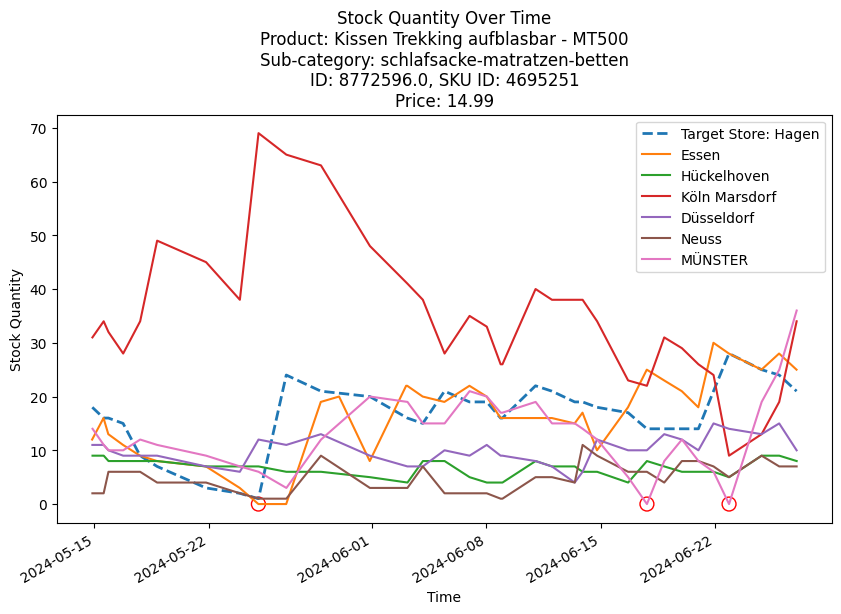

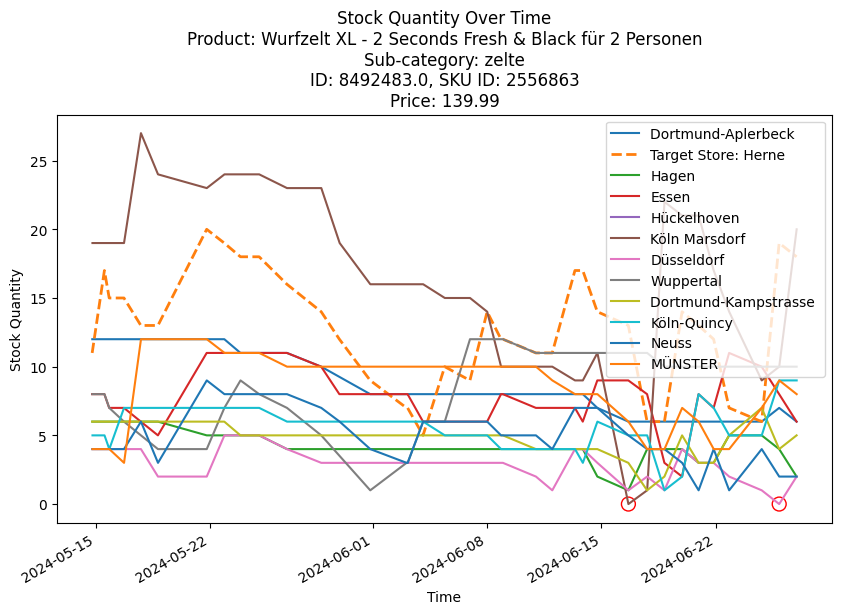

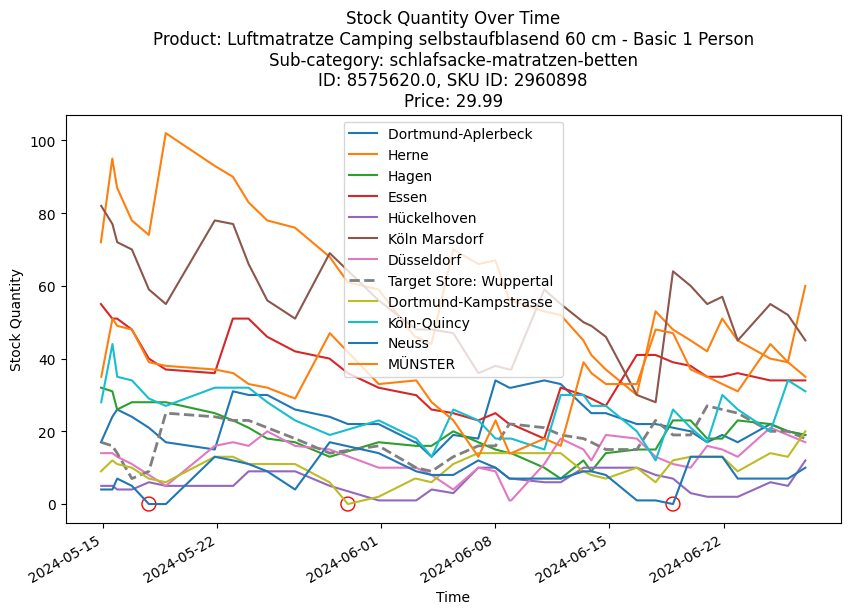

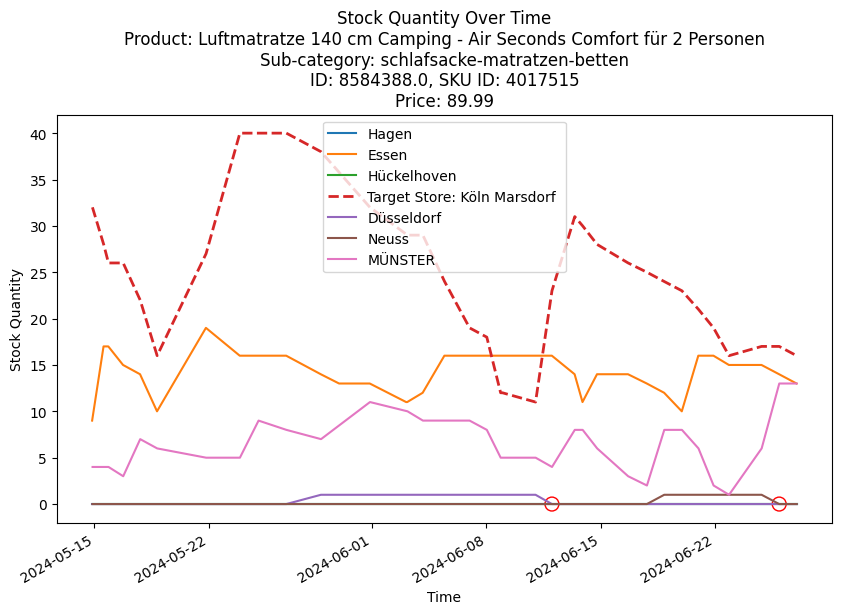

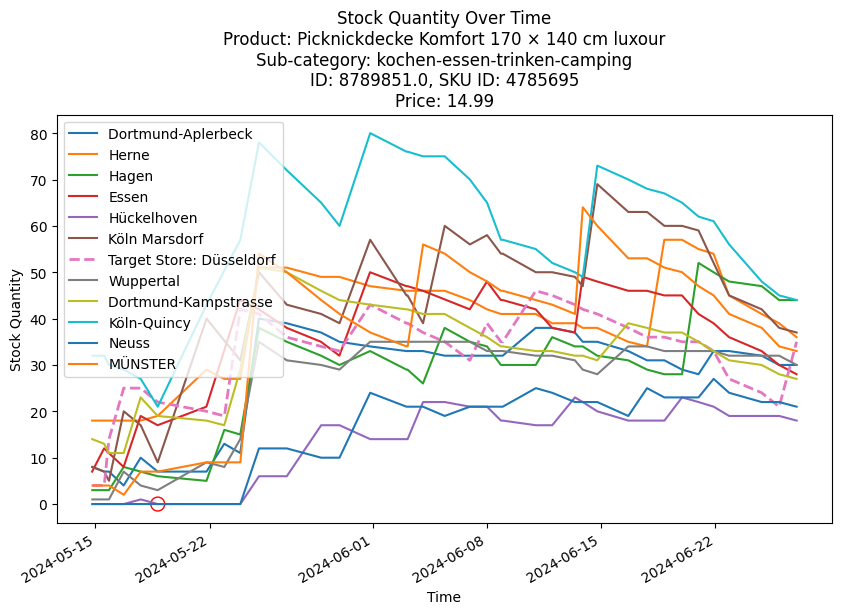

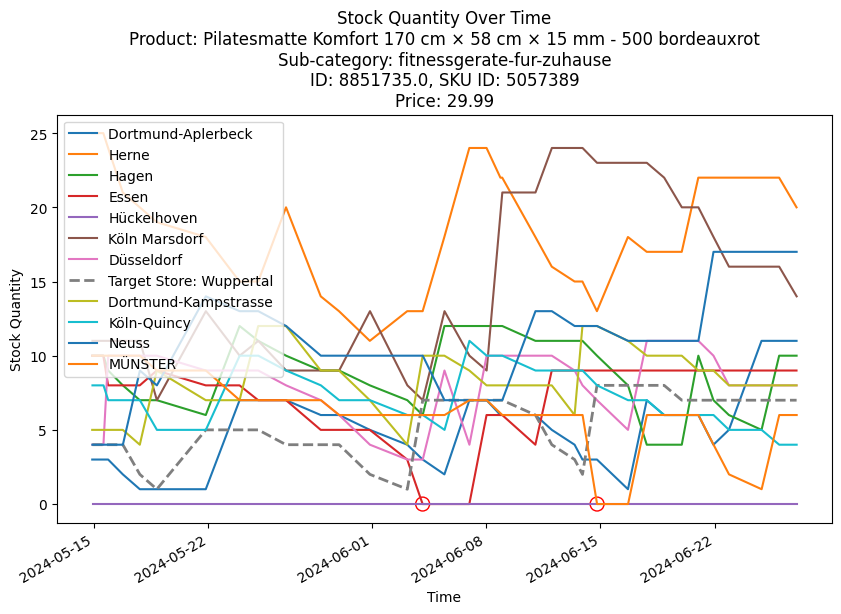

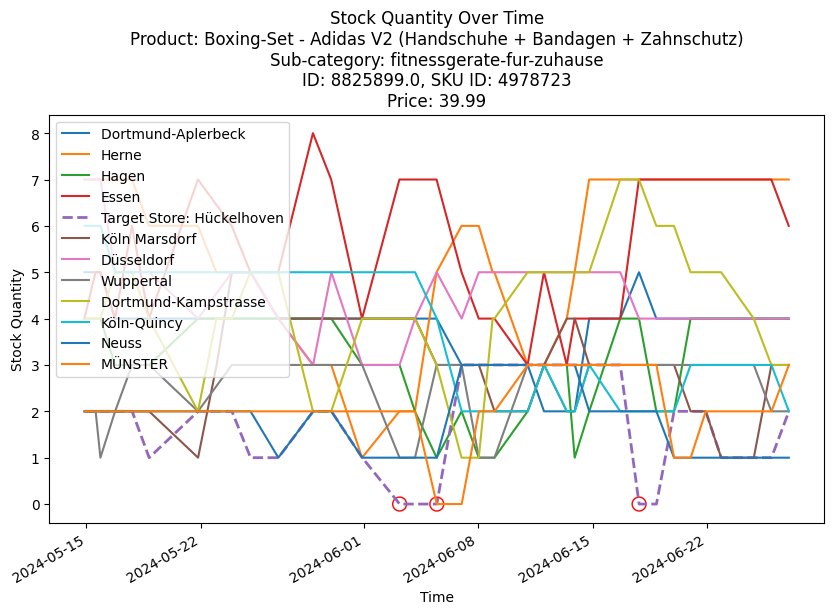

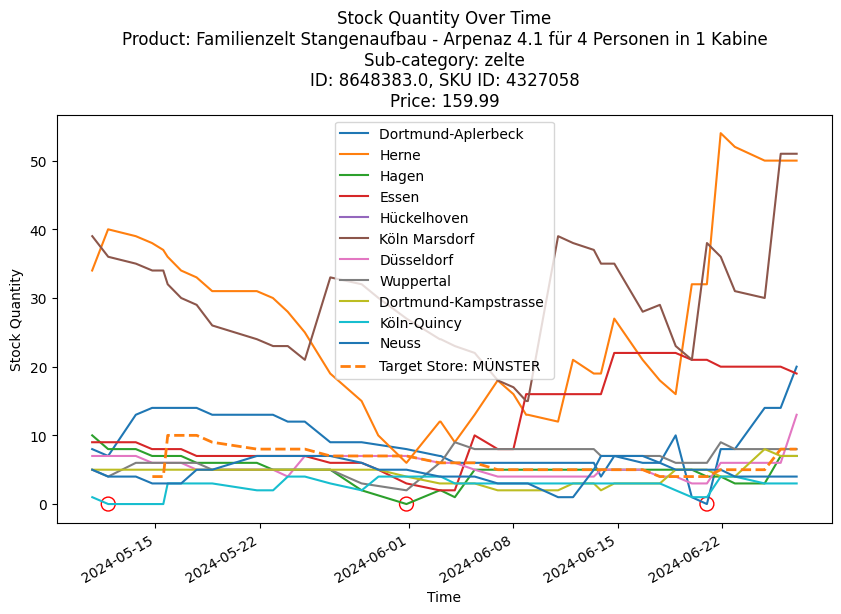

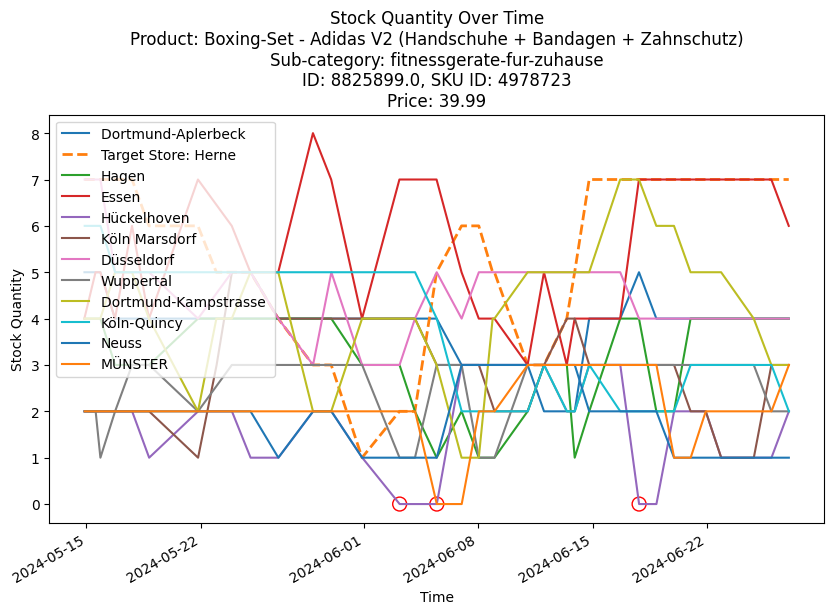

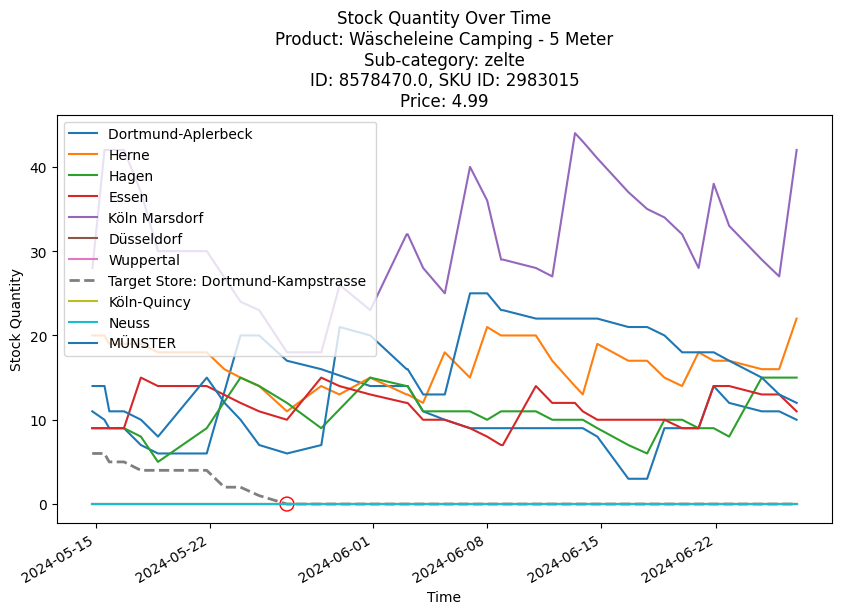

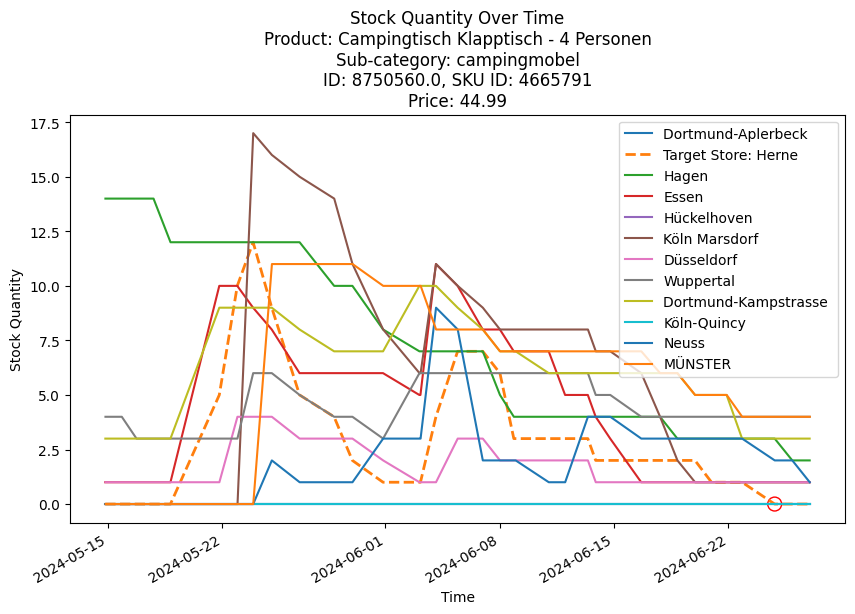

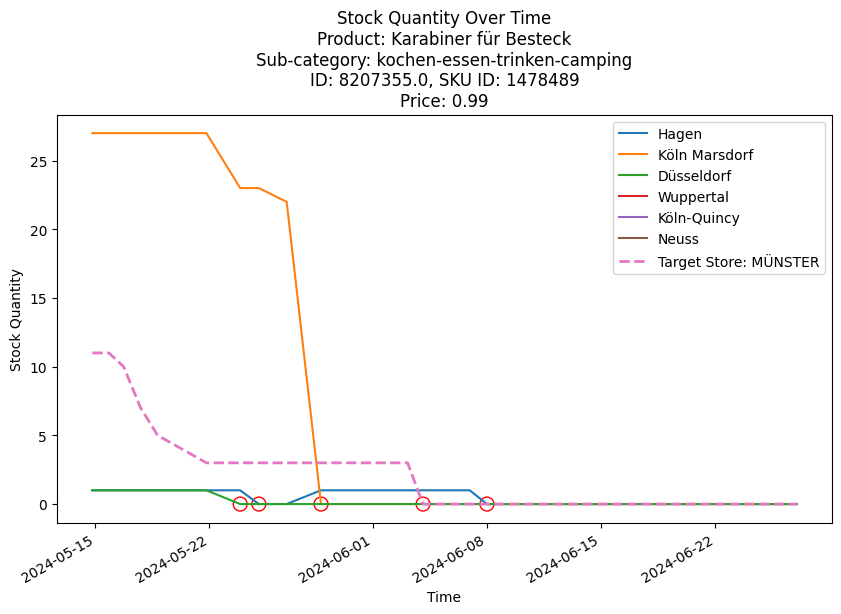

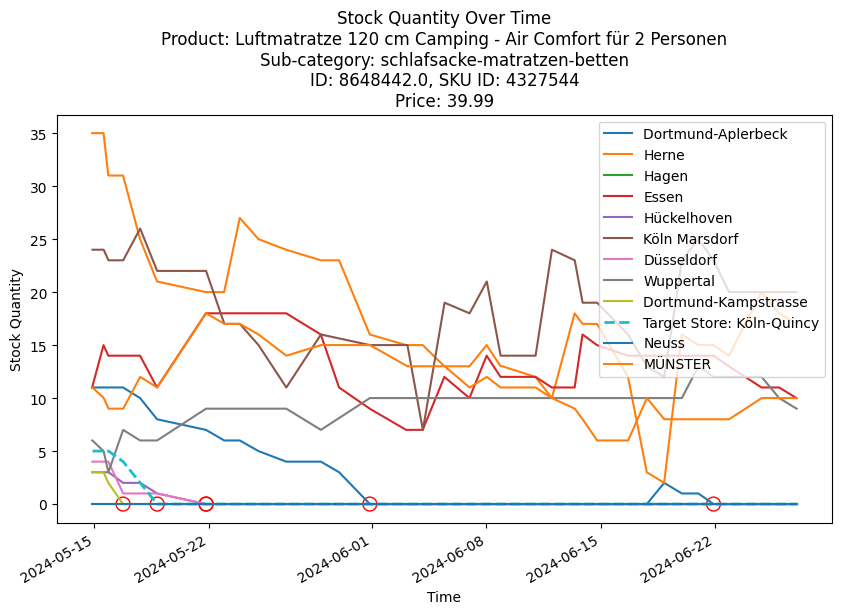

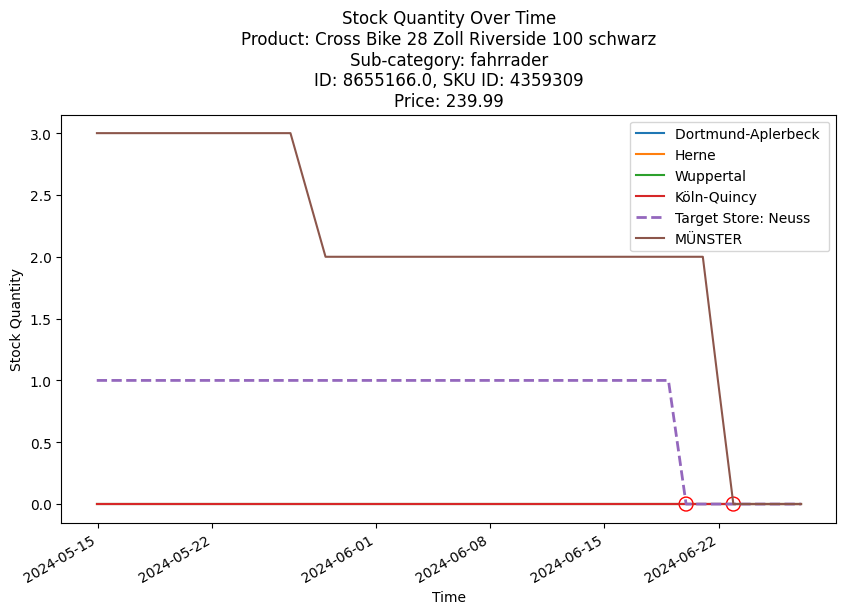

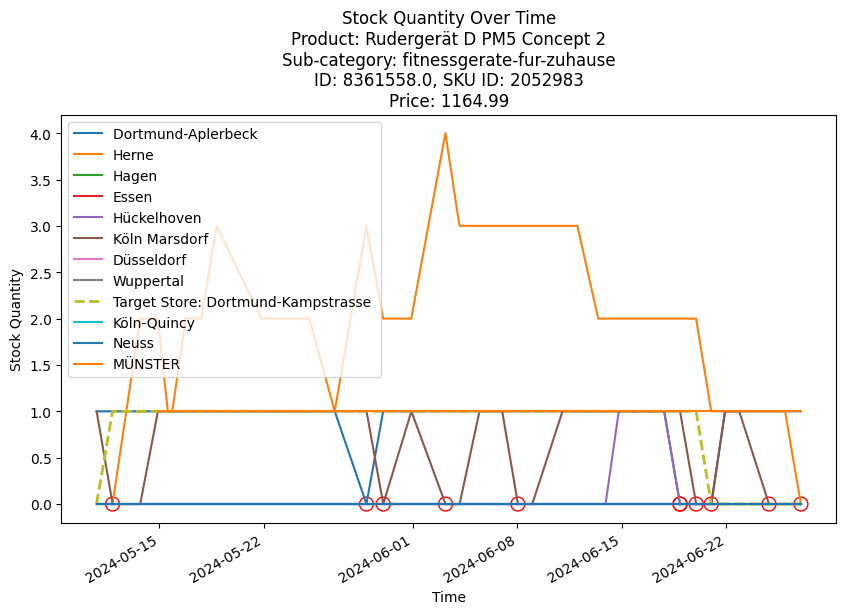

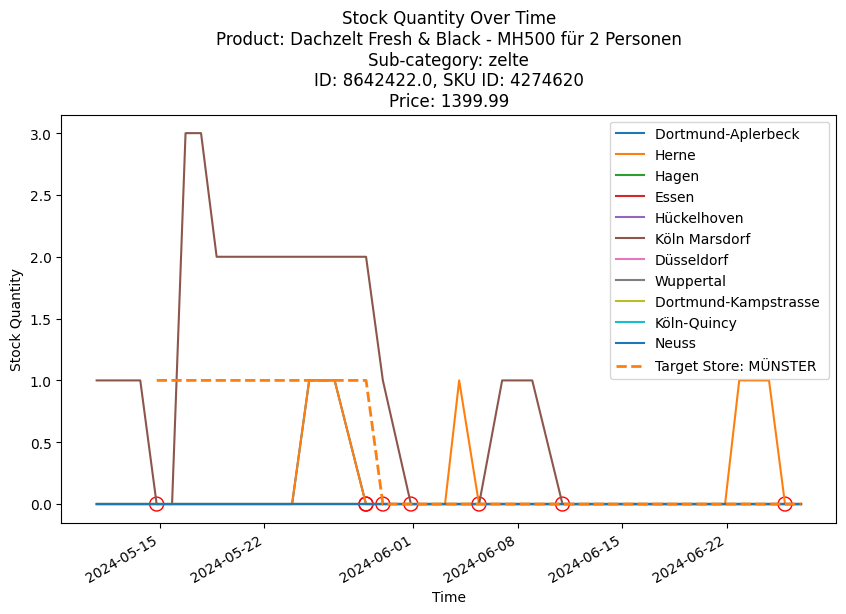

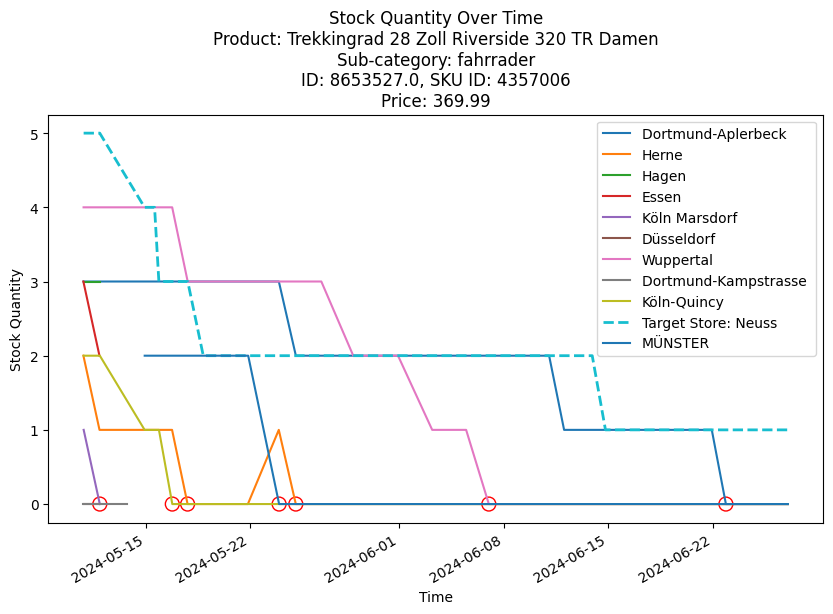

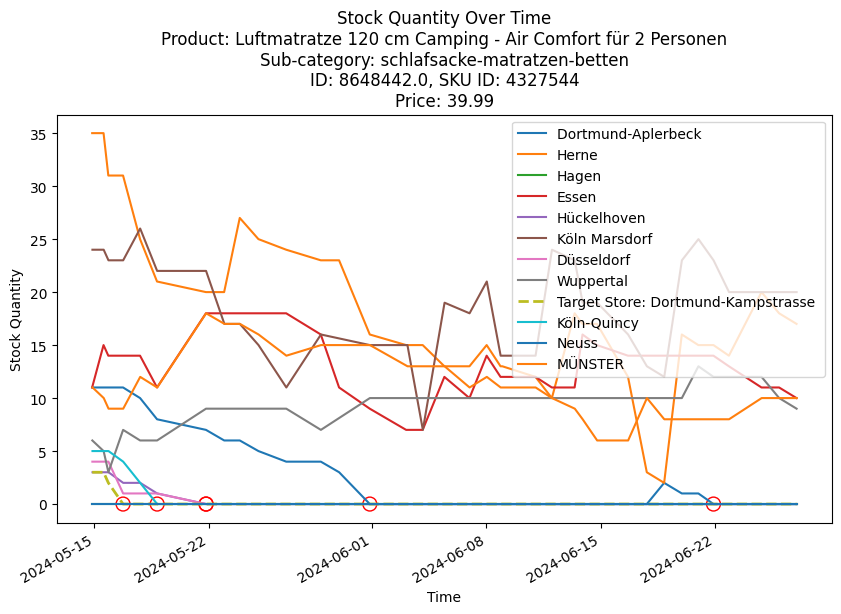

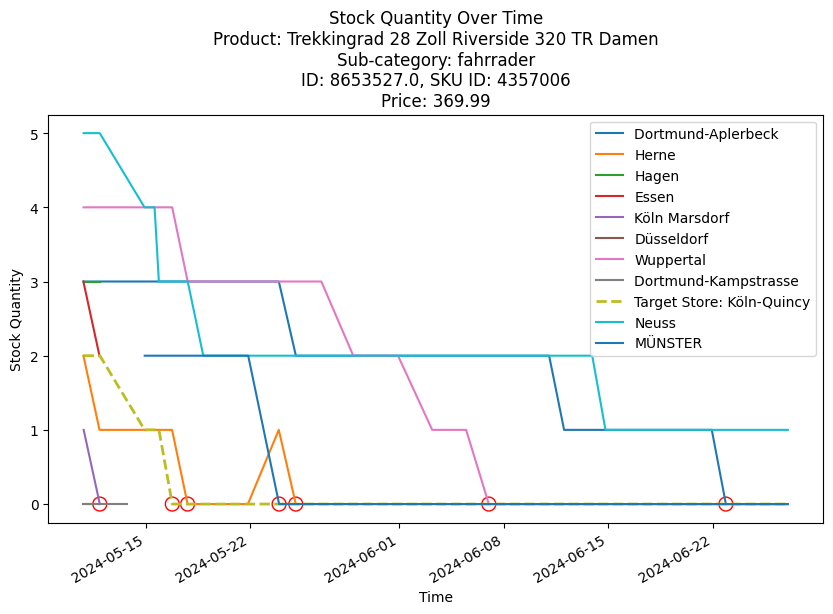

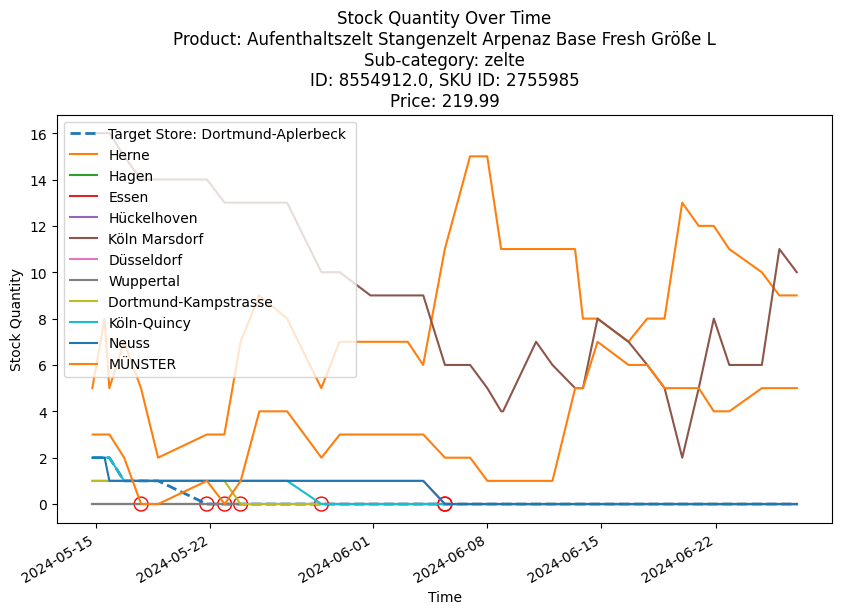

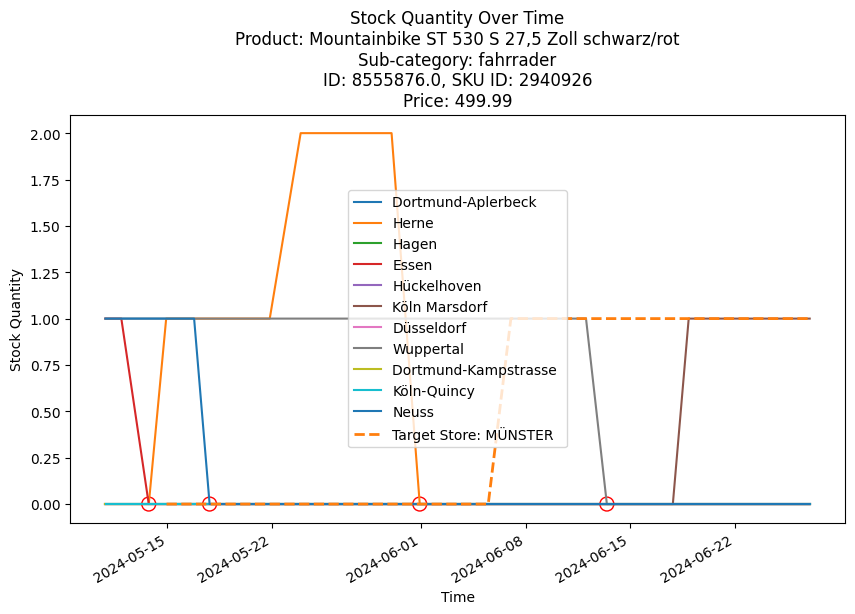

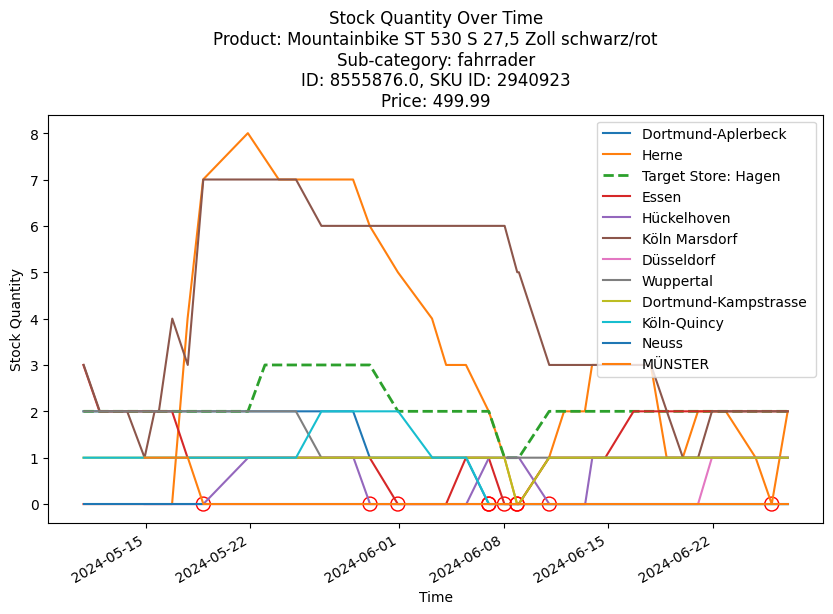

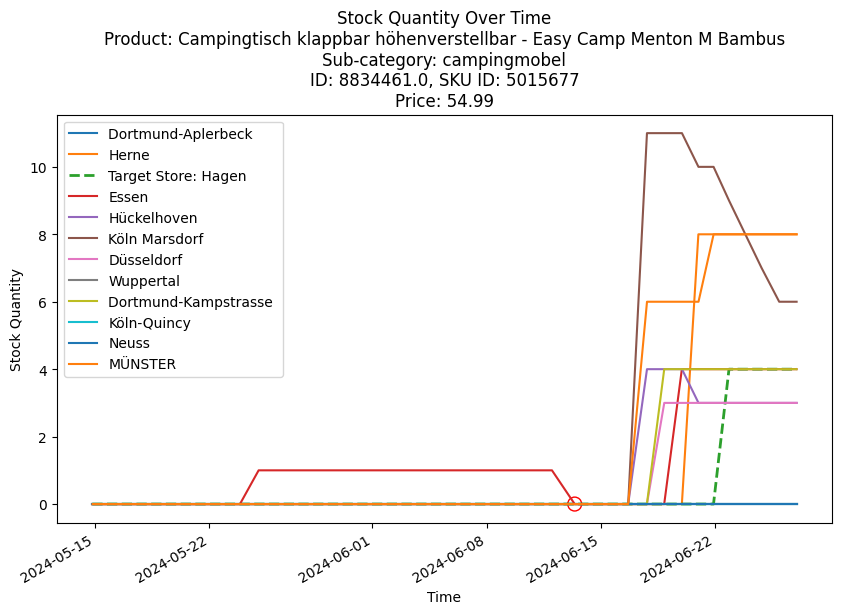

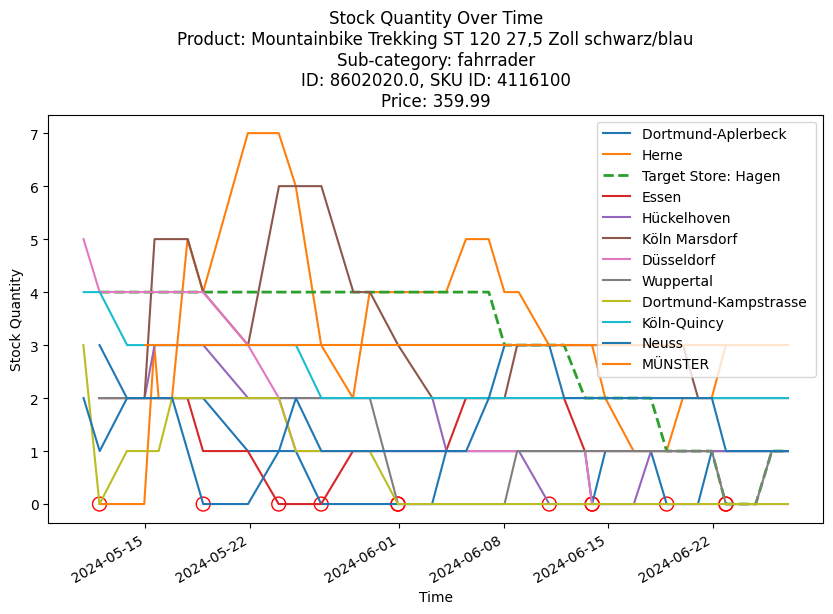

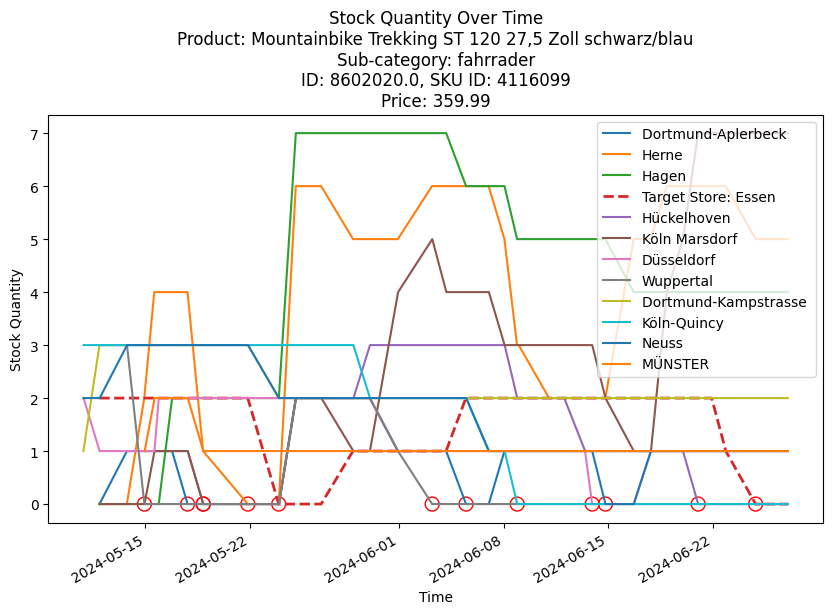

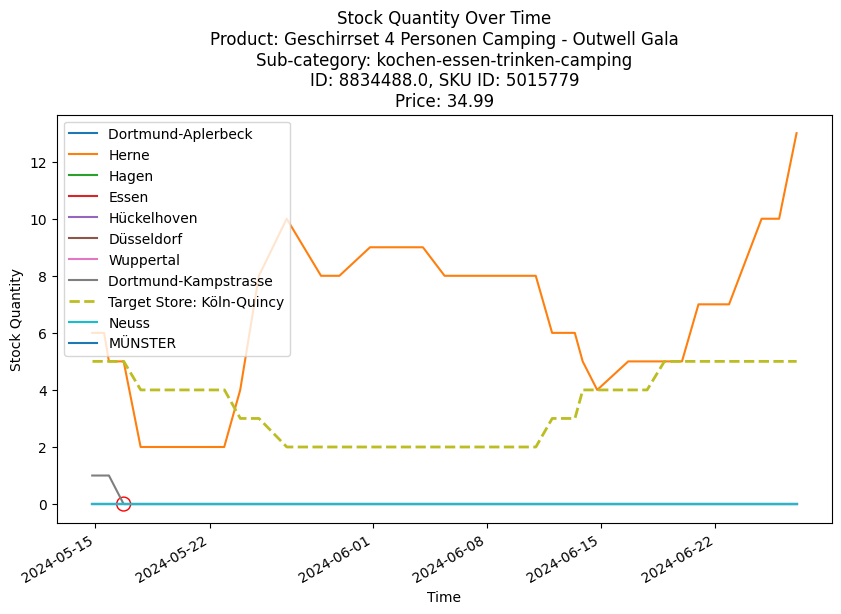

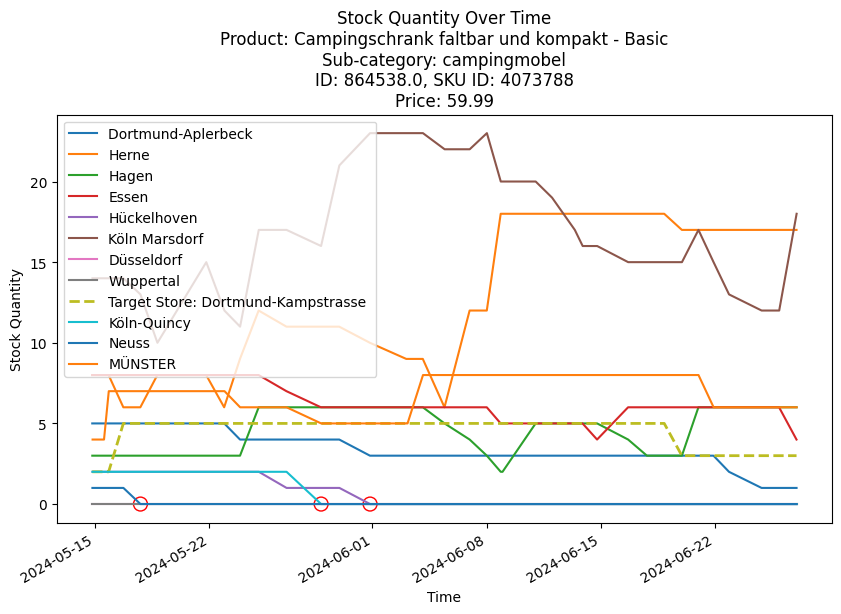

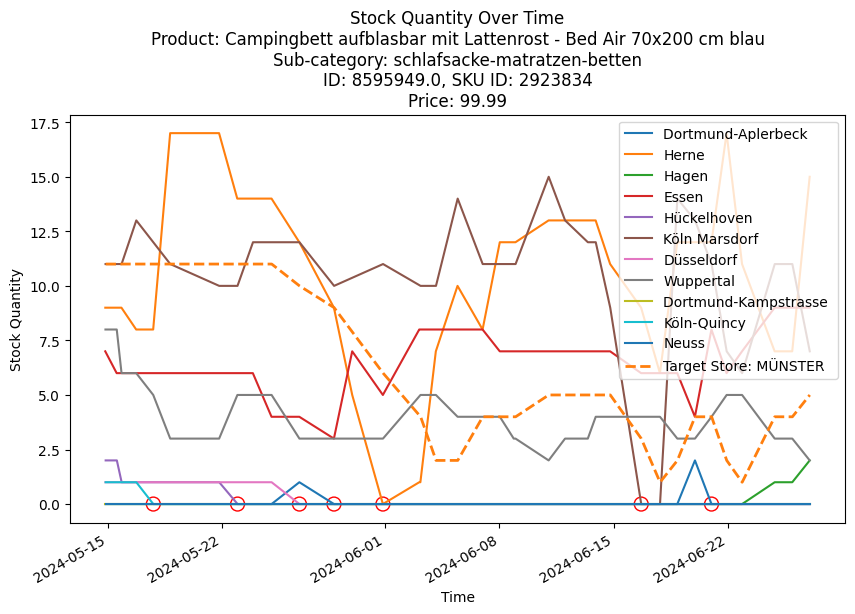

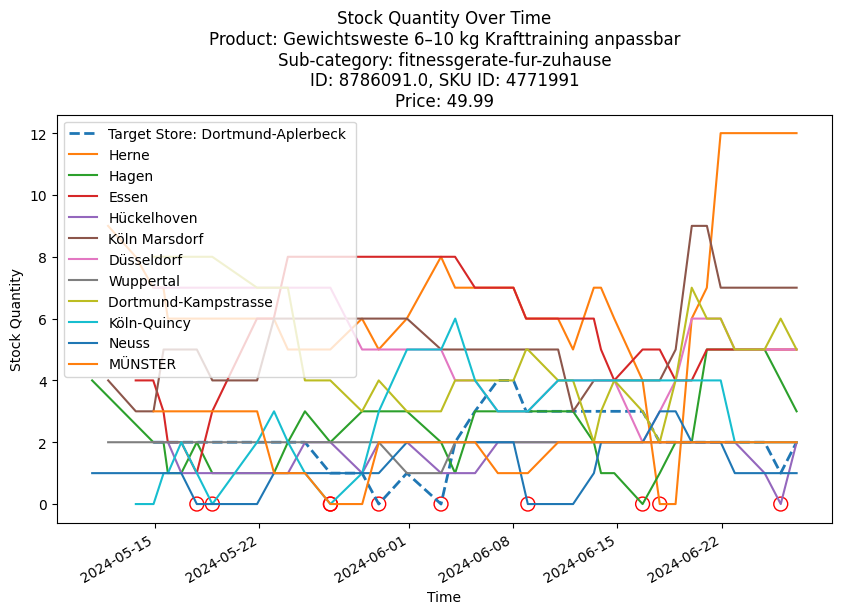

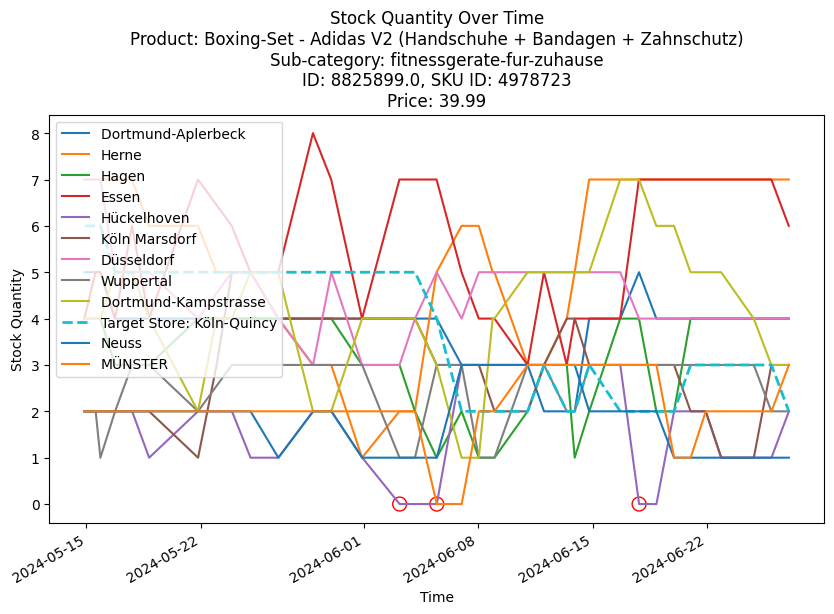

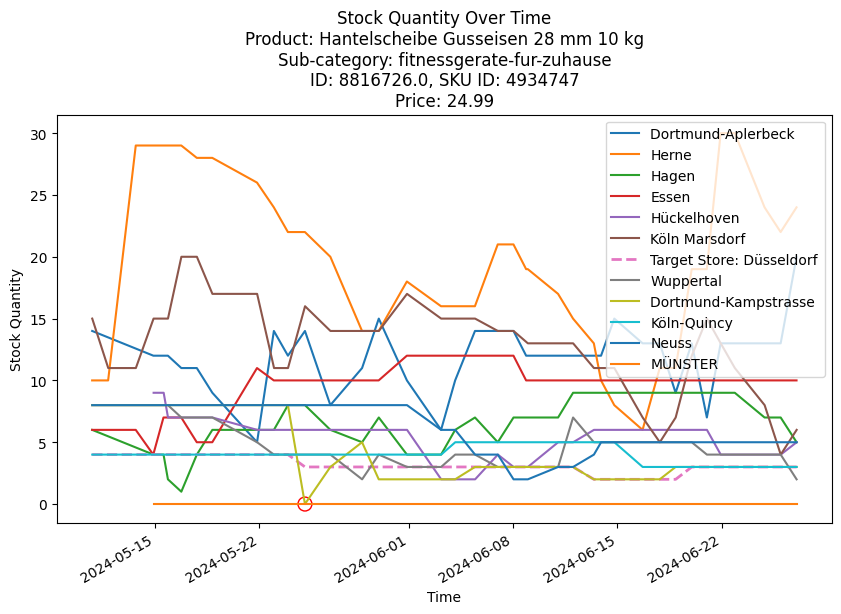

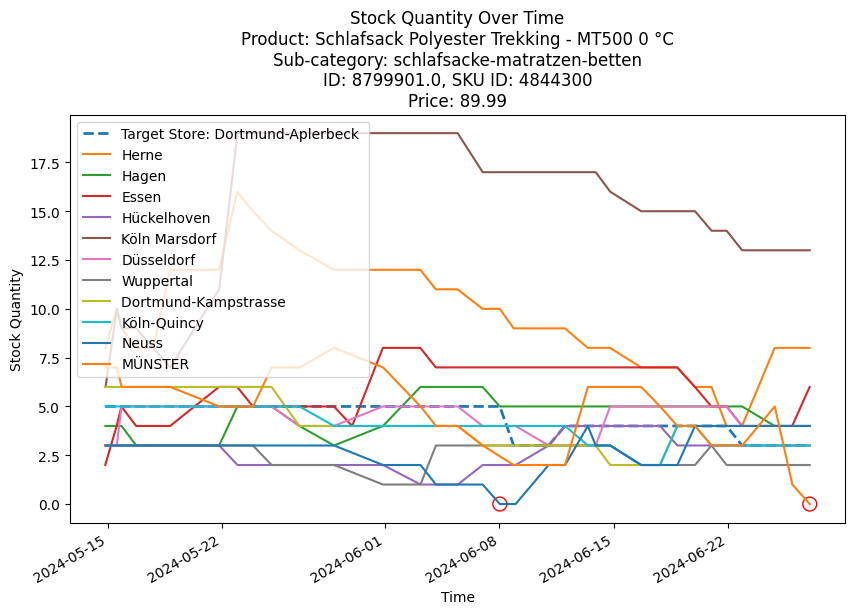

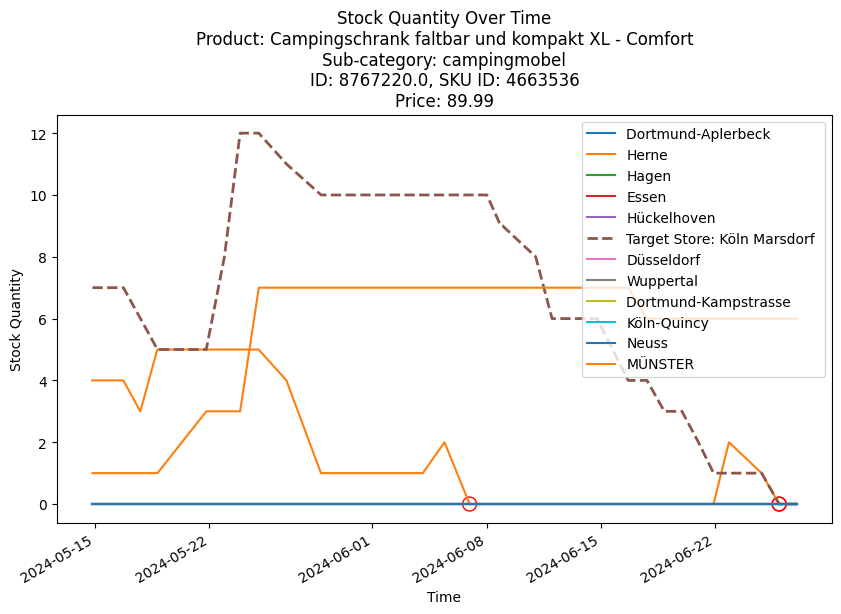

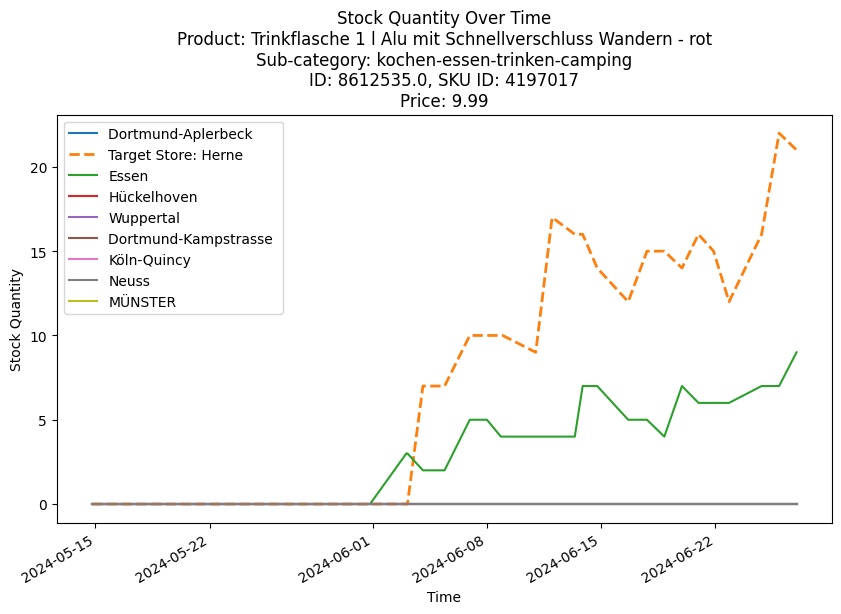

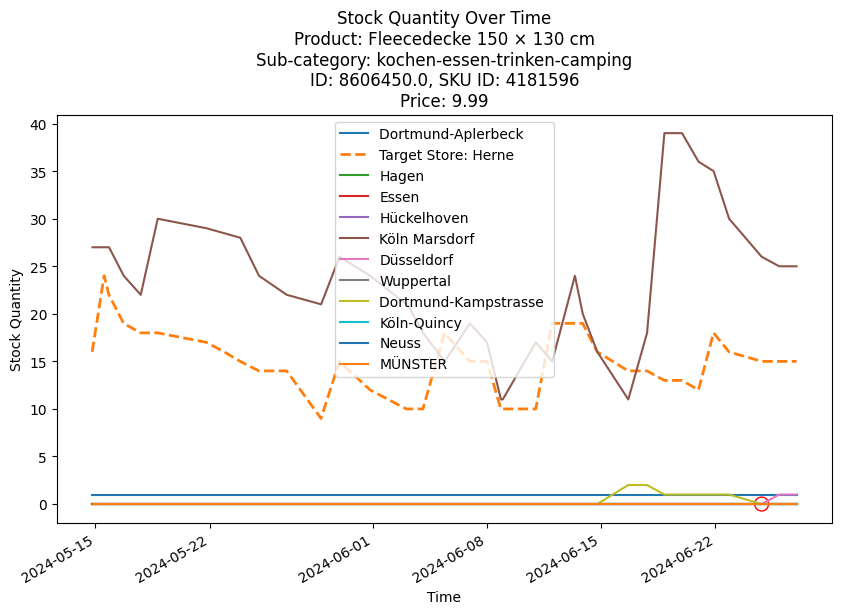

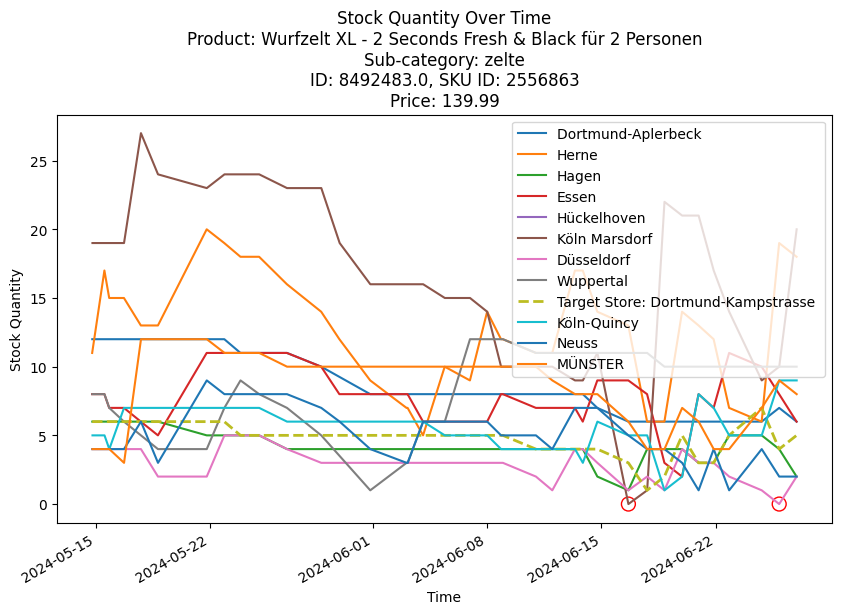

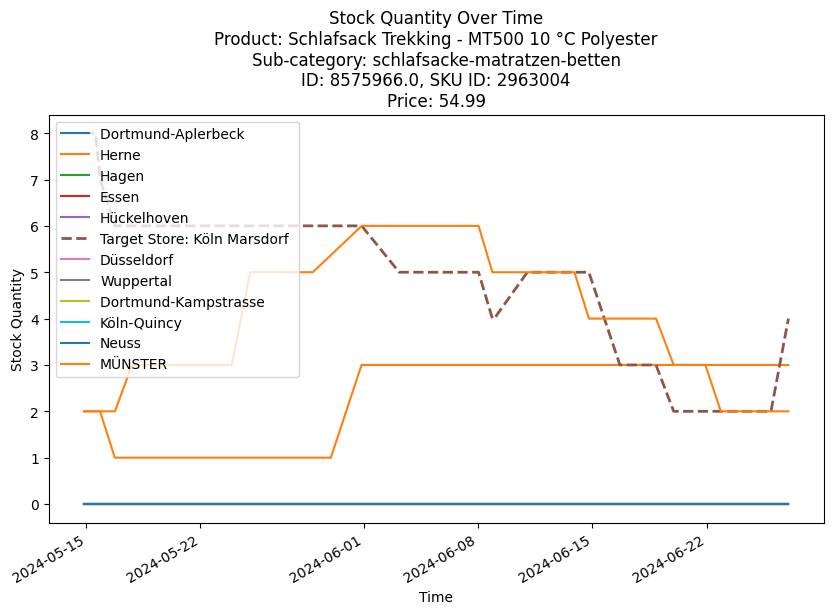

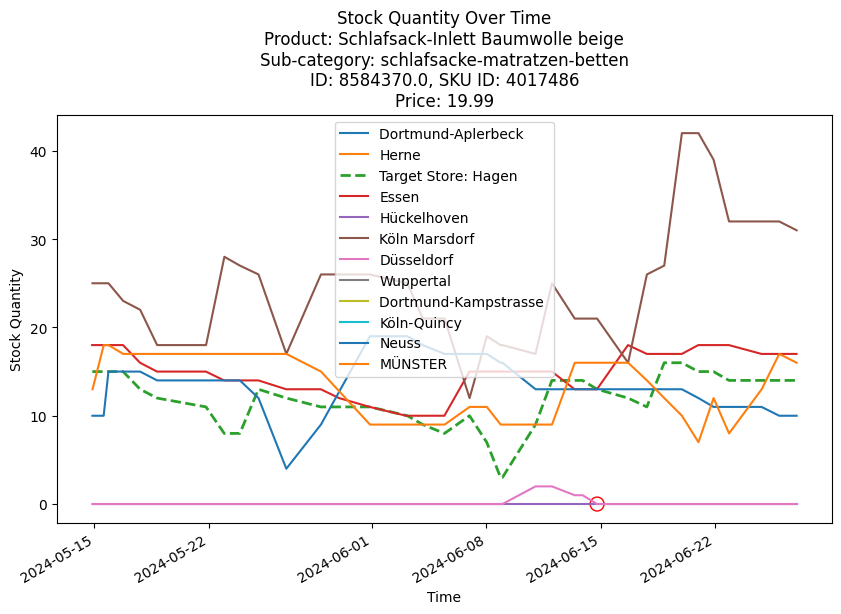

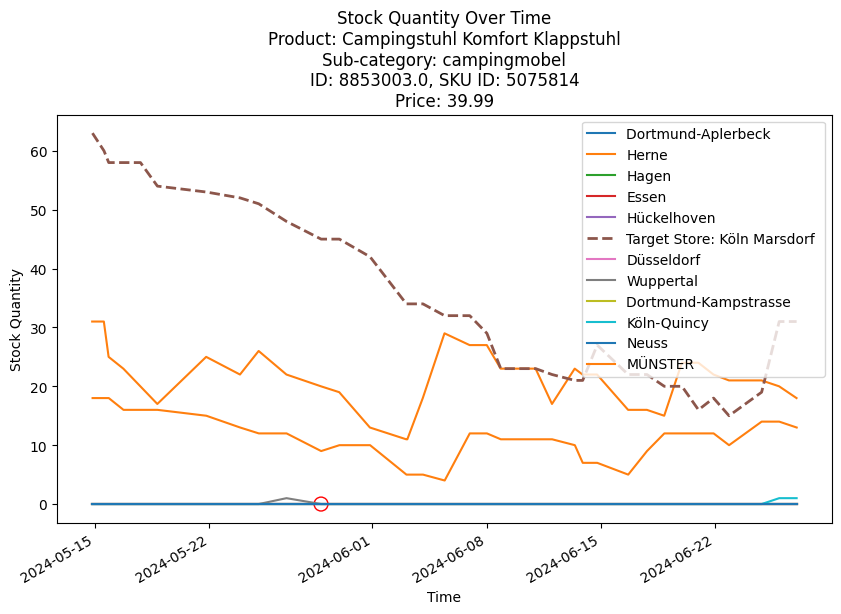

In [30]:
# Assuming significant_results contains the top 10 most influenced product variants
best_10_variants = significant_results.head(50)

# Plot for each of the top 10 product variants
for _, row in best_10_variants.iterrows():
    id = row['id']
    sku_id = row['store_skuId']
    store_id = row['store_storeId']
    product_data = df_relevant_variants[(df_relevant_variants['id'] == id) & (df_relevant_variants['store_skuId'] == sku_id)]
    product_name = product_data['product_name'].iloc[0]
    sub_category = product_data['sub_category'].iloc[0]
    price = product_data['price'].iloc[0]
    target_store = product_data[product_data['store_storeId'] == store_id]['store_storeName'].iloc[0]
    
    plot_stock_quantity_over_time(df_relevant_variants, id, sku_id, product_name, sub_category, price, target_store)
